# Imports

In [38]:
import numpy as np
import pandas as pd # 1.1
from sklearn.preprocessing import StandardScaler # 1.2
from sklearn.model_selection import train_test_split # 1.4
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from tqdm import tqdm

In [3]:
# FOR SVR Baseline model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# 1. Data Preprocessing

## 1.1 Get Data

### Player Data

In [4]:
player_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/nba_players.csv'
player_df = pd.read_csv(player_data_url)
player_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,mathcup,gamedate,winloss,minuters,pts,fgm,...,dreb,reb,ast,stl,blk,tov,pfo,plusminus,fp1,player
0,1710822472-1,https://www.nba.com/stats/players/boxscores,NaN,ATL,ATL @ LAL,03/18/2024,NaN,13,8,4,...,4,8,0,1,1,1,1,-7,22.6,Clint Capela
1,1710822472-2,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,19,8,3,...,3,4,3,2,2,1,2,-1,28.3,Mo Bamba
2,1710822472-3,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,16,11,4,...,1,2,1,1,1,0,1,1,20.9,Thomas Bryant
3,1710822472-4,https://www.nba.com/stats/players/boxscores,NaN,MIA,MIA @ PHI,03/18/2024,L,32,20,8,...,10,13,6,0,0,4,1,-19,40.6,Bam Adebayo
4,1710822472-5,https://www.nba.com/stats/players/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,24,12,4,...,1,2,1,0,1,1,1,11,17.9,Buddy Hield


In [5]:
player_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'mathcup', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'fp1', 'player'],
      dtype='object')

In [6]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage', 'fp1']
player_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
player_df['gamedate'] = pd.to_datetime(player_df['gamedate'])
player_df = player_df[player_df['gamedate'] != '2024-03-18']

# NBA made a typo so we gotta fix that
player_df['matchup'] = player_df['mathcup']
player_df.drop(columns=['mathcup'], inplace=True)

In [7]:
def calculate_fantasy_points(row):
    # Points scored
    points_scored = row['pts'] * 0.5
    # Rebounds, Assists, Steals, and Blocks
    rebound_points = (row['oreb'] + row['dreb']) * 1
    assist_points = row['ast'] * 1
    steal_points = row['stl'] * 2
    block_points = row['blk'] * 2
    # Turnovers
    turnover_points = row['tov'] * -1
    # Three-points made
    three_points = row['3pm'] * 0.5
    # Double-Double and Triple-Double
    double_digits = sum(i >= 10 for i in [row['pts'], row['oreb'] + row['dreb'], row['ast'], row['stl'], row['blk']])
    double_double_points = 1.0 if double_digits >= 2 else 0
    triple_double_points = 2.0 if double_digits >= 3 else 0
    # 40+ and 50+ bonuses
    fourty_pt_bonus = 2.0 * (row['pts'] >= 40)
    fifty_pt_bonus = 2.0 * (row['pts'] >= 50)
    # Total fantasy points
    total_points = (points_scored + rebound_points + assist_points +
                    steal_points + block_points + turnover_points + three_points +
                    double_double_points + triple_double_points +
                    fourty_pt_bonus + fifty_pt_bonus)
    return total_points

In [8]:
def get_opp_team(matchup):
    if '@' in matchup:
        return matchup.split(' @ ')[1]
    elif 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return None

In [9]:
# Helper function to determine home and away teams
def extract_teams(matchup):
    teams_a = matchup.split(' @ ')
    teams_h = matchup.split(' vs. ')
    if '@' in matchup:
        return teams_a[1], teams_a[0]
    else:
        return teams_h[0], teams_h[1]

# Function to create game_id
def create_game_id(row):
    home_team, away_team = extract_teams(row['matchup'])
    game_date = row['gamedate'].strftime('%Y-%m-%d')
    return f"{home_team}.{away_team}.{game_date}"

In [10]:
player_df['is_home'] = player_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0) # 1 if home game, 0 if away
player_df['winloss'] = player_df['winloss'].apply(lambda x: 1 if 'W' in x else 0) # 1 if W, 0 if L
player_df['fp'] = player_df.apply(calculate_fantasy_points, axis=1) # calculate fantasy points
player_df['opp_team'] = player_df['matchup'].apply(get_opp_team) # extract the opponent team name
player_df['game_id'] = player_df.apply(create_game_id, axis=1) # calculate the game id

# calculate how many days has passed since the start of the season till this game
season_start_date = pd.Timestamp('2023-10-24')
player_df['days_since'] = (player_df['gamedate'] - season_start_date).dt.days

player_df.head()

,team,gamedate,winloss,minuters,pts,fgm,fga,fgpercent,3pm,3pa,...,tov,pfo,plusminus,player,matchup,is_home,fp,opp_team,game_id,days_since
152,BOS,2024-03-17,1,35,14,6,15,40.0,2,5,...,1,0,16,Payton Pritchard,BOS @ WAS,0,28.0,WAS,WAS.BOS.2024-03-17,145
153,BOS,2024-03-17,1,23,9,3,7,42.9,3,6,...,0,0,7,Svi Mykhailiuk,BOS @ WAS,0,13.0,WAS,WAS.BOS.2024-03-17,145
154,BOS,2024-03-17,1,20,14,5,9,55.6,0,0,...,1,1,9,Luke Kornet,BOS @ WAS,0,17.0,WAS,WAS.BOS.2024-03-17,145
155,WAS,2024-03-17,0,22,8,4,7,57.1,0,2,...,0,3,-17,Johnny Davis,WAS vs. BOS,1,13.0,BOS,WAS.BOS.2024-03-17,145
156,WAS,2024-03-17,0,15,0,0,1,0.0,0,1,...,1,2,-14,Eugene Omoruyi,WAS vs. BOS,1,3.0,BOS,WAS.BOS.2024-03-17,145


In [11]:
player_df.columns

Index(['team', 'gamedate', 'winloss', 'minuters', 'pts', 'fgm', 'fga',
       'fgpercent', '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pfo', 'plusminus',
       'player', 'matchup', 'is_home', 'fp', 'opp_team', 'game_id',
       'days_since'],
      dtype='object')

### Team Data

In [12]:
team_data_url = 'https://raw.githubusercontent.com/BerkeAltiparmak/SportSense.AI/main/data/teamscores.csv'
team_df = pd.read_csv(team_data_url)

In [13]:
team_df.head()

,web-scraper-order,web-scraper-start-url,newpage,team,matchup,date,winloss,min,pts,fgm,...,ftpercent,oreb,dreb,reb,ast,stl,blk,tov,pfidk,plusminus
0,1710880555-1,https://www.nba.com/stats/teams/boxscores,NaN,CLE,CLE @ IND,03/18/2024,W,240,108,38,...,71.4,9,30,39,27,8,4,14,18,5
1,1710880555-2,https://www.nba.com/stats/teams/boxscores,NaN,IND,IND vs. CLE,03/18/2024,L,240,103,42,...,62.5,14,31,45,28,8,3,11,24,-5
2,1710880555-3,https://www.nba.com/stats/teams/boxscores,NaN,DET,DET @ BOS,03/18/2024,L,240,94,36,...,86.7,8,35,43,21,6,3,13,15,-25
3,1710880555-4,https://www.nba.com/stats/teams/boxscores,NaN,BOS,BOS vs. DET,03/18/2024,W,240,119,43,...,84.6,15,38,53,30,8,8,11,9,25
4,1710880555-5,https://www.nba.com/stats/teams/boxscores,NaN,PHI,PHI vs. MIA,03/18/2024,W,240,98,37,...,91.7,7,39,46,23,7,12,12,16,7


In [14]:
team_df.columns

Index(['web-scraper-order', 'web-scraper-start-url', 'newpage', 'team',
       'matchup', 'date', 'winloss', 'min', 'pts', 'fgm', 'fga', 'fgpercent',
       '3pm', '3pa', '3ppercent', 'ftm', 'fta', 'ftpercent', 'oreb', 'dreb',
       'reb', 'ast', 'stl', 'blk', 'tov', 'pfidk', 'plusminus'],
      dtype='object')

In [15]:
# remove unnecessary columns
columns_to_remove = ['web-scraper-order', 'web-scraper-start-url', 'newpage']
team_df.drop(columns=columns_to_remove, inplace=True)

# only consider games before 2024-03-18, the time we got the data (there were incompelete games)
team_df['gamedate'] = pd.to_datetime(team_df['date'])
team_df = team_df[team_df['gamedate'] != '2024-03-18']

In [16]:
team_df['is_home'] = team_df['matchup'].apply(lambda x: 1 if 'vs.' in x else 0)
team_df['opp_team'] = team_df['matchup'].apply(get_opp_team)
team_df['game_id'] = team_df.apply(create_game_id, axis=1)
team_df.head()

,team,matchup,date,winloss,min,pts,fgm,fga,fgpercent,3pm,...,ast,stl,blk,tov,pfidk,plusminus,gamedate,is_home,opp_team,game_id
16,LAC,LAC vs. ATL,03/17/2024,L,240,93,28,74,37.8,11,...,17,10,5,16,13,-17,2024-03-17,1,ATL,LAC.ATL.2024-03-17
17,ATL,ATL @ LAC,03/17/2024,W,240,110,41,84,48.8,17,...,32,10,7,16,22,17,2024-03-17,0,LAC,LAC.ATL.2024-03-17
18,BKN,BKN @ SAS,03/17/2024,L,265,115,47,102,46.1,8,...,29,13,5,12,20,-7,2024-03-17,0,SAS,SAS.BKN.2024-03-17
19,SAS,SAS vs. BKN,03/17/2024,W,265,122,46,99,46.5,9,...,30,6,10,18,17,7,2024-03-17,1,BKN,SAS.BKN.2024-03-17
20,ORL,ORL vs. TOR,03/17/2024,W,240,111,43,85,50.6,11,...,22,7,4,15,16,15,2024-03-17,1,TOR,ORL.TOR.2024-03-17


### Merging

In [17]:
own_team_df = team_df.copy()
opp_team_df = team_df.copy()

In [18]:
# renaming columns for the team data
team_rename_columns = {
    'pts': 'team_pts',
    'fgm': 'team_fgm',
    'fga': 'team_fga',
    'fgpercent': 'team_fgpercent',
    '3pm': 'team_3pm',
    '3pa': 'team_3pa',
    '3ppercent': 'team_3ppercent',
    'ftm': 'team_ftm',
    'fta': 'team_fta',
    'ftpercent': 'team_ftpercent',
    'oreb': 'team_oreb',
    'dreb': 'team_dreb',
    'reb': 'team_reb',
    'ast': 'team_ast',
    'stl': 'team_stl',
    'blk': 'team_blk',
    'tov': 'team_tov',
    'pfidk': 'team_pfidk',
    'plusminus': 'team_plusminus'
}

# renaming columns for the opponent team data
opp_rename_columns = {
    'pts': 'opp_pts',
    'fgm': 'opp_fgm',
    'fga': 'opp_fga',
    'fgpercent': 'opp_fgpercent',
    '3pm': 'opp_3pm',
    '3pa': 'opp_3pa',
    '3ppercent': 'opp_3ppercent',
    'ftm': 'opp_ftm',
    'fta': 'opp_fta',
    'ftpercent': 'opp_ftpercent',
    'oreb': 'opp_oreb',
    'dreb': 'opp_dreb',
    'reb': 'opp_reb',
    'ast': 'opp_ast',
    'stl': 'opp_stl',
    'blk': 'opp_blk',
    'tov': 'opp_tov',
    'pfidk': 'opp_pfidk',
    'plusminus': 'opp_plusminus'
}

own_team_df.rename(columns=team_rename_columns, inplace=True)
opp_team_df.rename(columns=opp_rename_columns, inplace=True)

In [19]:
opp_team_df.columns

Index(['team', 'matchup', 'date', 'winloss', 'min', 'opp_pts', 'opp_fgm',
       'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa', 'opp_3ppercent',
       'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb', 'opp_dreb',
       'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov', 'opp_pfidk',
       'opp_plusminus', 'gamedate', 'is_home', 'opp_team', 'game_id'],
      dtype='object')

In [20]:
# merging player data with own team data
initial_merged_df = pd.merge(player_df, own_team_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from team_df that are redundant
initial_merged_df.drop([col for col in initial_merged_df.columns if 'drop' in col], axis=1, inplace=True)

# merging the last df with opponent team data
df = pd.merge(initial_merged_df, opp_team_df, left_on=['game_id', 'opp_team'], right_on=['game_id', 'team'], suffixes=('', '_drop'))
# drop the columns from opp_team_df that are redundant
df.drop([col for col in df.columns if 'drop' in col], axis=1, inplace=True)

In [21]:
# reorder the columns for visual purposes
columns_order = ['player', 'team', 'opp_team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'opp_team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]
df.head()

,player,team,opp_team,gamedate,days_since,winloss,minuters,pts,fgm,fga,...,opp_oreb,opp_dreb,opp_reb,opp_ast,opp_stl,opp_blk,opp_tov,opp_pfidk,opp_plusminus,fp
0,Payton Pritchard,BOS,WAS,2024-03-17,145,1,35,14,6,15,...,10,30,40,24,3,5,16,20,-26,28.0
1,Svi Mykhailiuk,BOS,WAS,2024-03-17,145,1,23,9,3,7,...,10,30,40,24,3,5,16,20,-26,13.0
2,Luke Kornet,BOS,WAS,2024-03-17,145,1,20,14,5,9,...,10,30,40,24,3,5,16,20,-26,17.0
3,Sam Hauser,BOS,WAS,2024-03-17,145,1,23,30,10,13,...,10,30,40,24,3,5,16,20,-26,29.0
4,Neemias Queta,BOS,WAS,2024-03-17,145,1,8,0,0,0,...,10,30,40,24,3,5,16,20,-26,1.0


In [22]:
df.columns

Index(['player', 'team', 'opp_team', 'gamedate', 'days_since', 'winloss',
       'minuters', 'pts', 'fgm', 'fga', 'fgpercent', '3pm', '3pa', '3ppercent',
       'ftm', 'fta', 'ftpercent', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk',
       'tov', 'pfo', 'plusminus', 'matchup', 'is_home', 'game_id', 'date',
       'min', 'team_pts', 'team_fgm', 'team_fga', 'team_fgpercent', 'team_3pm',
       'team_3pa', 'team_3ppercent', 'team_ftm', 'team_fta', 'team_ftpercent',
       'team_oreb', 'team_dreb', 'team_reb', 'team_ast', 'team_stl',
       'team_blk', 'team_tov', 'team_pfidk', 'team_plusminus', 'opp_pts',
       'opp_fgm', 'opp_fga', 'opp_fgpercent', 'opp_3pm', 'opp_3pa',
       'opp_3ppercent', 'opp_ftm', 'opp_fta', 'opp_ftpercent', 'opp_oreb',
       'opp_dreb', 'opp_reb', 'opp_ast', 'opp_stl', 'opp_blk', 'opp_tov',
       'opp_pfidk', 'opp_plusminus', 'fp'],
      dtype='object')

## 1.2 Z-Score Normalization / Standardization

In [23]:
"""
# Select the columns with player stats
stats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here

# Initialize the scaler
scaler = StandardScaler()

# Normalize the stats using Z-score normalization
df[stats_columns] = scaler.fit_transform(df[stats_columns])
"""

"\n# Select the columns with player stats\nstats_columns = ['points', 'rebounds', 'assists', 'steals', 'blocks']  # Make sure we got all the columns here\n\n# Initialize the scaler\nscaler = StandardScaler()\n\n# Normalize the stats using Z-score normalization\ndf[stats_columns] = scaler.fit_transform(df[stats_columns])\n"

## 1.25: Dashes Cleanup

In [24]:
# Create a boolean mask
mask = (df == '-')

# Use `any` to check each column
columns_with_dash = mask.any(axis=0)

# Print the columns that contain '-'
print(columns_with_dash[columns_with_dash].index.tolist())

# Convert specific columns to strings
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(str)

# Replace '-' with '0'
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].replace('-', '0')

# Convert these columns back to floats
df[['fgpercent', '3ppercent', 'ftpercent']] = df[['fgpercent', '3ppercent', 'ftpercent']].astype(float)


['fgpercent', '3ppercent', 'ftpercent']


## 1.275: EXPERIMENTAL REMOVING OF PLAYERS THAT HAVENT PLAYED 10 GAMES AND THAT ARE NOT IN TOP 150

1.29. ADDING MORE FEATURES FOR DEBUGGING

In [25]:
players_list = list(df.groupby('player')['fp'].mean().reset_index().sort_values(by='fp', ascending=False)['player'])
players_dict = {players_list[i]: i for i in range(len(players_list))}
players_inv_dict = {i: players_list[i] for i in range(len(players_list))}

In [26]:
int(str(df.iloc[132]['gamedate'])[-14:-12]) * 1000 + int(str(df.iloc[132]['gamedate'])[-11:-9])

3017

In [27]:
def intify_player(player):
    return players_dict[player] / 1000

def intify_gamedate(gamedate):
    return (int(str(gamedate)[-14:-12]) * 1000 + int(str(gamedate)[-11:-9])) / 100000

In [28]:
df['int_player'] = df['player'].apply(intify_player)
df['int_gamedate'] = df['gamedate'].apply(intify_gamedate)

## 1.3 One-Hot Encoding

In [29]:
# one-hot encode the categorical columns
df = pd.get_dummies(df, columns=['opp_team'])

In [30]:
## reorder the columns for visual purposes
columns_order = ['player', 'team', 'gamedate', 'days_since'] + [col for col in df.columns if col not in ['player', 'team', 'gamedate', 'days_since', 'fp']] + ['fp']
df = df[columns_order]

In [31]:
df.head()

,player,team,gamedate,days_since,winloss,minuters,pts,fgm,fga,fgpercent,...,opp_team_ORL,opp_team_PHI,opp_team_PHX,opp_team_POR,opp_team_SAC,opp_team_SAS,opp_team_TOR,opp_team_UTA,opp_team_WAS,fp
0,Payton Pritchard,BOS,2024-03-17,145,1,35,14,6,15,40.0,...,False,False,False,False,False,False,False,False,True,28.0
1,Svi Mykhailiuk,BOS,2024-03-17,145,1,23,9,3,7,42.9,...,False,False,False,False,False,False,False,False,True,13.0
2,Luke Kornet,BOS,2024-03-17,145,1,20,14,5,9,55.6,...,False,False,False,False,False,False,False,False,True,17.0
3,Sam Hauser,BOS,2024-03-17,145,1,23,30,10,13,76.9,...,False,False,False,False,False,False,False,False,True,29.0
4,Neemias Queta,BOS,2024-03-17,145,1,8,0,0,0,0.0,...,False,False,False,False,False,False,False,False,True,1.0


In [32]:
df.columns

Index(['player', 'team', 'gamedate', 'days_since', 'winloss', 'minuters',
       'pts', 'fgm', 'fga', 'fgpercent',
       ...
       'opp_team_ORL', 'opp_team_PHI', 'opp_team_PHX', 'opp_team_POR',
       'opp_team_SAC', 'opp_team_SAS', 'opp_team_TOR', 'opp_team_UTA',
       'opp_team_WAS', 'fp'],
      dtype='object', length=101)

## 1.4 Split per player



In [33]:
class NBAFantasyDatasetFlat(Dataset):
    def __init__(self, dataframe, look_back=10):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the data.
        """
        self.dataframe = dataframe
        # player + game_date logic:
        self.player_game_indices = self._get_player_game_indices()
        # for normalization:
        self.scaler = StandardScaler()
        self._normalize_features()
        # for "last 10 game" approach:
        self.look_back = look_back

    def _normalize_features(self):
        features = self.dataframe.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'int_player', 'int_gamedate', 'date', 'matchup'])
        self.scaler.fit(features)
        self.dataframe.loc[:, features.columns] = self.scaler.transform(features)

    def _get_player_game_indices(self):
        """Get a list of tuples indicating the start and end indices of each player's games."""
        player_game_indices = []
        players = self.dataframe['player'].unique()
        count = 0
        for player in players:
            count += 1
            player_data = self.dataframe[self.dataframe['player'] == player]
            #player_data = player_data.sort_values(by='days_since').reset_index(drop=True) # im not sure
            for i in range(10, len(player_data)):
                start_index = player_data.index[i-10]
                end_index = player_data.index[i]
                player_game_indices.append((start_index, end_index))
        return player_game_indices

    def __len__(self):
        return len(self.player_game_indices)

    def __getitem__(self, idx):
        start_index, end_index = self.player_game_indices[idx]
        player_data = self.dataframe.iloc[start_index:end_index]
        # Flatten the last 10 games' features into one long vector
        flattened_features = player_data.drop(columns=['player', 'team', 'gamedate', 'game_id', 'fp', 'matchup', 'date']).values.flatten()
        target = self.dataframe.iloc[end_index]['fp']
        return torch.tensor(flattened_features, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [34]:
sdf = df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True)
print(sdf.head())

        player team   gamedate  days_since  winloss  minuters  pts  fgm  fga  \
0  A.J. Lawson  DAL 2023-12-01          38        0         4    1    0    1   
1  A.J. Lawson  DAL 2023-12-02          39        0        19   12    4   10   
2  A.J. Lawson  DAL 2023-12-06          43        1         7    4    2    2   
3  A.J. Lawson  DAL 2023-12-08          45        1         7    2    1    3   
4  A.J. Lawson  DAL 2023-12-11          48        1        14    4    2    7   

   fgpercent  ...  opp_team_ORL  opp_team_PHI  opp_team_PHX  opp_team_POR  \
0        0.0  ...         False         False         False         False   
1       40.0  ...         False         False         False         False   
2      100.0  ...         False         False         False         False   
3       33.3  ...         False         False         False          True   
4       28.6  ...         False         False         False         False   

   opp_team_SAC  opp_team_SAS  opp_team_TOR  opp_team_UT

In [ ]:
def collate_fn(batch):
    """
    Custom collate function for handling variable-length sequences.
    """
    features, targets = zip(*batch)
    # Pad the sequences to the maximum length in the batch
    features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
    targets = torch.stack(targets)
    return features_padded, targets

In [35]:
# Create DataLoader for the dataset
dataset = NBAFantasyDatasetFlat(df.sort_values(by=['player', 'days_since'], ascending=True, inplace=False).reset_index(drop=True))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Batch size of 1 since we're treating each sample independently

## 1.5 Train-Test Split

In [36]:
# Define the split sizes
TRAIN_RATIO = 0.8
train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Support Vector Regression (SVR) Baseline

In [37]:
train_features = []
train_targets = []
for features, target in train_dataloader:
    train_features.append(features.numpy())
    train_targets.append(target.numpy())

# Flatten the list of arrays into a single array
X_train = np.vstack(train_features)
y_train = np.concatenate(train_targets)

# Define and train the SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.01)
svr_model.fit(X_train, y_train)

SVR(epsilon=0.01)

Mean Squared Error: 45.10362445829796
Accuracy (within ±5 FP): 58.80%


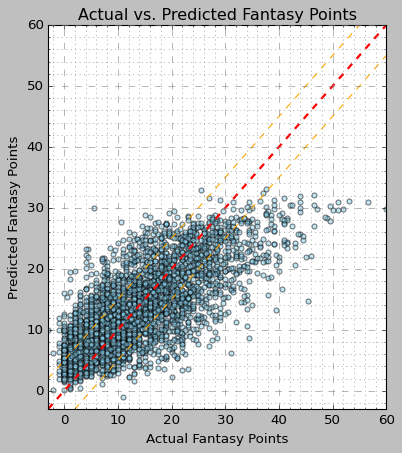

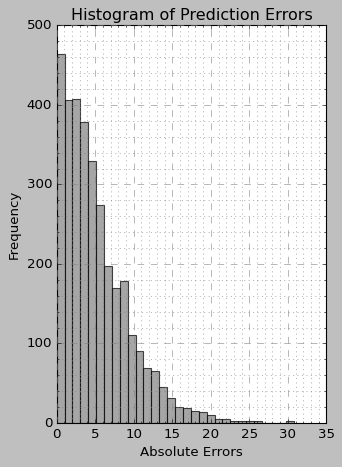

(45.10362445829796, 0.5880048221820374)

In [44]:
# Enable LaTeX rendering in plots
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set classic style for plots
plt.style.use('classic')

def evaluate_model(model, dataloader, threshold):
    # Prepare the data for evaluation
    X_test = []
    y_test = []
    for features, target in dataloader:
        X_test.append(features.numpy())  # Ensure your data is numpy array
        y_test.append(target.numpy())

    # Flatten the list of arrays into a single array
    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Predict using the trained model
    predictions = model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse}')

    # Calculate accuracy based on the threshold
    accuracy = np.mean(np.abs(predictions - y_test) <= threshold)
    print(f'Accuracy (within ±{threshold} FP): {accuracy * 100:.2f}%')

    # Calculate errors
    errors = np.abs(predictions - y_test)

    plt.figure(figsize=(12, 6))

    # Actual vs Predicted plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions, alpha=0.5, edgecolor='k', facecolor='skyblue')
    min_val, max_val = min(y_test), max(y_test)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)  # Diagonal line for perfect predictions
    plt.plot([min_val, max_val], [min_val + 5, max_val + 5], '--', lw=1, color='orange')  # Upper threshold line
    plt.plot([min_val, max_val], [min_val - 5, max_val - 5], '--', lw=1, color='orange')  # Lower threshold line
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.xlabel('Actual Fantasy Points')
    plt.ylabel('Predicted Fantasy Points')
    plt.title('Actual vs. Predicted Fantasy Points')
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.show()

    # Plot Error Histogram
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=30, color='gray', alpha=0.7)
    plt.xlabel('Absolute Errors')
    plt.ylabel('Frequency')
    plt.title('Histogram of Prediction Errors')
    plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth='0.5', color='gray')

    plt.tight_layout()
    plt.show()

    return mse, accuracy

threshold = 5
evaluate_model(svr_model, test_dataloader, threshold)

Mean Squared Error: 39.56694031483508
Accuracy (within ±5 FP): 62.53%


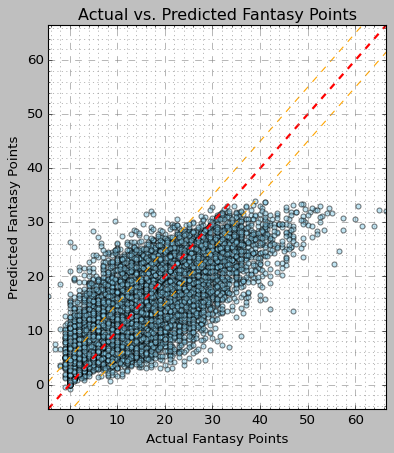

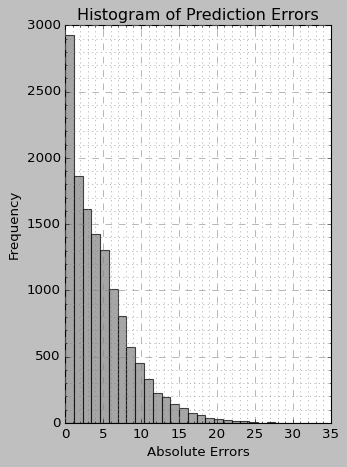

(39.56694031483508, 0.6252731519855323)

In [45]:
evaluate_model(svr_model, train_dataloader, threshold)